# Medical text categorization
Simo Hyttinen<br>
Last edited: 11.03.2018<br>
Cognitive Systems for Health Technology Applications<br>
<a href="https://www.metropolia.fi/en">Helsinki Metropolia University of Applied Sciences</a>


## 1. Objectives

The objective of this assignment is to use a recurrent and convolutional neural network to classify medical abstracts into 23 different categories. 

## 2. Required libraries

In [61]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\simoh\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [62]:
import keras

In [87]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop

## 3. Data description and preprocessing

I import the data using a function that looks inside a given folder for the specified folders that are listed in the labels_list variable, and saves the text in the files within a given folder into the texts variable, and the corresponding label to a labels variable.

In [64]:
train_data_dir = 'cardiovascular/training'
test_data_dir = 'cardiovascular/test'

labels_list = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15',
              'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23']


def import_data(data_dir):
    labels = []
    texts = []
    for label_type in labels_list:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'C01':
                labels.append(0)
            elif label_type == 'C02':
                labels.append(1)
            elif label_type == 'C03':
                labels.append(2)
            elif label_type == 'C04':
                labels.append(3)
            elif label_type == 'C05':
                labels.append(4)
            elif label_type == 'C06':
                labels.append(5)
            elif label_type == 'C07':
                labels.append(6)
            elif label_type == 'C08':
                labels.append(7)
            elif label_type == 'C09':
                labels.append(8)
            elif label_type == 'C10':
                labels.append(9)
            elif label_type == 'C11':
                labels.append(10)
            elif label_type == 'C12':
                labels.append(11)
            elif label_type == 'C13':
                labels.append(12)
            elif label_type == 'C14':
                labels.append(13)
            elif label_type == 'C15':
                labels.append(14)
            elif label_type == 'C16':
                labels.append(15)
            elif label_type == 'C17':
                labels.append(16)
            elif label_type == 'C18':
                labels.append(17)
            elif label_type == 'C19':
                labels.append(18)
            elif label_type == 'C20':
                labels.append(18)
            elif label_type == 'C21':
                labels.append(20)
            elif label_type == 'C22':
                labels.append(21)
            elif label_type == 'C23':
                labels.append(22)
            else:
                labels.append(23) # if there are 23s, there is either a folder that's not supposed
                                  # to be there or a misspelled folder name in labels_list.
    return texts, labels

train_texts, train_labels = import_data(train_data_dir)
test_texts, test_labels = import_data(test_data_dir)

In [65]:
print(amax(test_labels))
print(amax(train_labels))

22
22


The maximum value in the labels is 22, which means there were no hickups in the data importing.

In [68]:
maxlen = 100
training_samples = len(train_texts)
validation_samples = len(test_texts)
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
sequences = tokenizer.texts_to_sequences(train_texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

trdata = pad_sequences(sequences, maxlen=maxlen)
trlabels = np.asarray(train_labels)

print('Shape of data tensor:', trdata.shape)
print('Shape of label tensor:', trlabels.shape)

indices = np.arange(trdata.shape[0])
random.shuffle(indices)
trdata = trdata[indices]
trlabels = trlabels[indices]

Found 30857 unique tokens.
Shape of data tensor: (10433, 100)
Shape of label tensor: (10433,)


In [69]:
tokenizer.fit_on_texts(test_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

tedata = pad_sequences(test_sequences, maxlen=maxlen)
telabels = np.asarray(test_labels)

print('Shape of data tensor:', tedata.shape)
print('Shape of label tensor:', telabels.shape)

Shape of data tensor: (12733, 100)
Shape of label tensor: (12733,)


In [70]:
trlabels = keras.utils.np_utils.to_categorical(trlabels, 23)
telabels = keras.utils.np_utils.to_categorical(telabels, 23)

## 4. Modeling and compilation

The first model I try here has an embedding layer and two GRU layers followed by a dense layer. 

In [71]:
model = keras.models.Sequential()

model.add(keras.layers.Embedding(max_words, 32, input_length=maxlen))
model.add(keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(keras.layers.GRU(32, dropout=0.3, recurrent_dropout=0.3, activation="relu"))
model.add(keras.layers.Dense(23, activation="softmax"))

model.summary()

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 32)           320000    
_________________________________________________________________
gru_7 (GRU)                  (None, 100, 32)           6240      
_________________________________________________________________
gru_8 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 23)                759       
Total params: 333,239
Trainable params: 333,239
Non-trainable params: 0
_________________________________________________________________


For comparison, I wanted to also try a basic 1D convolutional model with an embedding layer, a couple of 1D convolutional and pooling layers and a dense layer at the end.

In [88]:
model_conv1d = keras.models.Sequential()
model_conv1d.add(keras.layers.Embedding(max_words, 128, input_length=maxlen))
model_conv1d.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_conv1d.add(keras.layers.MaxPooling1D(5))
model_conv1d.add(keras.layers.Conv1D(32, 7, activation='relu'))
model_conv1d.add(keras.layers.GlobalMaxPooling1D())
model_conv1d.add(keras.layers.Dense(23, activation="softmax"))
model_conv1d.summary()
model_conv1d.compile(optimizer=RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 32)            28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 12, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 23)                759       
Total params: 1,316,663
Trainable params: 1,316,663
Non-trainable params: 0
_________________________________________________________________


## 5. Training and Validation


I did 100 epochs with each model to see what the progression with them was over time. Since my PC is subject to random crashes and freezes, I save the model and the history after training the model. 

In [75]:
model_history = model.fit(trdata, trlabels, epochs=100, batch_size=64, validation_data=(tedata, telabels))

Train on 10433 samples, validate on 12733 samples
Epoch 1/100
10433/10433 [==============================] - 37s 4ms/step - loss: 2.8491 - acc: 0.1695 - val_loss: 2.7873 - val_acc: 0.1691
Epoch 2/100
10433/10433 [==============================] - 32s 3ms/step - loss: 2.7495 - acc: 0.1719 - val_loss: 2.7927 - val_acc: 0.1691
Epoch 3/100
10433/10433 [==============================] - 32s 3ms/step - loss: 2.7057 - acc: 0.1720 - val_loss: 2.8039 - val_acc: 0.1691
Epoch 4/100
10433/10433 [==============================] - 32s 3ms/step - loss: 2.6497 - acc: 0.1851 - val_loss: 2.8696 - val_acc: 0.1469
Epoch 5/100
10433/10433 [==============================] - 32s 3ms/step - loss: 2.6078 - acc: 0.1938 - val_loss: 2.8498 - val_acc: 0.1615
Epoch 6/100
10433/10433 [==============================] - 32s 3ms/step - loss: 2.5689 - acc: 0.2019 - val_loss: 2.8942 - val_acc: 0.1517
Epoch 7/100
10433/10433 [==============================] - 32s 3ms/step - loss: 2.5309 - acc: 0.2199 - val_loss: 2.8917 - 

10433/10433 [==============================] - 34s 3ms/step - loss: 1.5066 - acc: 0.5002 - val_loss: 4.0318 - val_acc: 0.1169
Epoch 60/100
10433/10433 [==============================] - 34s 3ms/step - loss: 1.5136 - acc: 0.4944 - val_loss: 4.0317 - val_acc: 0.1091
Epoch 61/100
10433/10433 [==============================] - 34s 3ms/step - loss: 1.4961 - acc: 0.4987 - val_loss: 4.0146 - val_acc: 0.1147
Epoch 62/100
10433/10433 [==============================] - 34s 3ms/step - loss: 1.4903 - acc: 0.4991 - val_loss: 4.0108 - val_acc: 0.1081
Epoch 63/100
10433/10433 [==============================] - 35s 3ms/step - loss: 1.4783 - acc: 0.5042 - val_loss: 4.0161 - val_acc: 0.1056
Epoch 64/100
10433/10433 [==============================] - 35s 3ms/step - loss: 1.4717 - acc: 0.5073 - val_loss: 4.0890 - val_acc: 0.1099
Epoch 65/100
10433/10433 [==============================] - 35s 3ms/step - loss: 1.4560 - acc: 0.5072 - val_loss: 4.0526 - val_acc: 0.1107
Epoch 66/100
10433/10433 [==============

In [76]:
model.save("gru_model.h5")

In [80]:
import pickle
with open('gruHistory', 'wb') as file_pi:
        pickle.dump(model_history.history, file_pi)

In [89]:
model_conv1d_history = model_conv1d.fit(trdata, trlabels, epochs=100, batch_size=64, validation_data=(tedata, telabels))

Train on 10433 samples, validate on 12733 samples
Epoch 1/100
10433/10433 [==============================] - 23s 2ms/step - loss: 3.0468 - acc: 0.1186 - val_loss: 2.9640 - val_acc: 0.1680
Epoch 2/100
10433/10433 [==============================] - 23s 2ms/step - loss: 2.8724 - acc: 0.1730 - val_loss: 2.8333 - val_acc: 0.1691
Epoch 3/100
10433/10433 [==============================] - 23s 2ms/step - loss: 2.7891 - acc: 0.1724 - val_loss: 2.8093 - val_acc: 0.1691
Epoch 4/100
10433/10433 [==============================] - 23s 2ms/step - loss: 2.7621 - acc: 0.1724 - val_loss: 2.7985 - val_acc: 0.1691
Epoch 5/100
10433/10433 [==============================] - 23s 2ms/step - loss: 2.7466 - acc: 0.1724 - val_loss: 2.7926 - val_acc: 0.1691
Epoch 6/100
10433/10433 [==============================] - 23s 2ms/step - loss: 2.7343 - acc: 0.1724 - val_loss: 2.7895 - val_acc: 0.1691
Epoch 7/100
10433/10433 [==============================] - 23s 2ms/step - loss: 2.7231 - acc: 0.1724 - val_loss: 2.7860 - 

10433/10433 [==============================] - 23s 2ms/step - loss: 1.4130 - acc: 0.5284 - val_loss: 3.2375 - val_acc: 0.1501
Epoch 60/100
10433/10433 [==============================] - 23s 2ms/step - loss: 1.3934 - acc: 0.5346 - val_loss: 3.2342 - val_acc: 0.1501
Epoch 61/100
10433/10433 [==============================] - 23s 2ms/step - loss: 1.3736 - acc: 0.5351 - val_loss: 3.2462 - val_acc: 0.1454
Epoch 62/100
10433/10433 [==============================] - 23s 2ms/step - loss: 1.3545 - acc: 0.5408 - val_loss: 3.2682 - val_acc: 0.1422
Epoch 63/100
10433/10433 [==============================] - 23s 2ms/step - loss: 1.3363 - acc: 0.5407 - val_loss: 3.2835 - val_acc: 0.1457
Epoch 64/100
10433/10433 [==============================] - 23s 2ms/step - loss: 1.3174 - acc: 0.5442 - val_loss: 3.2778 - val_acc: 0.1443
Epoch 65/100
10433/10433 [==============================] - 23s 2ms/step - loss: 1.3005 - acc: 0.5465 - val_loss: 3.3126 - val_acc: 0.1496
Epoch 66/100
10433/10433 [==============

In [92]:
model_conv1d.save("conv1d_model.h5")

In [93]:
with open('conv1dHistory', 'wb') as file_pi:
        pickle.dump(model_conv1d_history.history, file_pi)

## 6. Evaluation

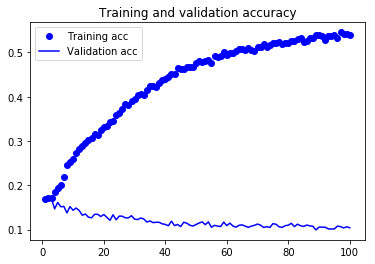

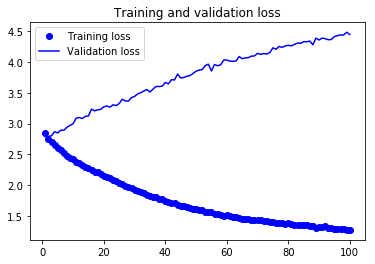

In [94]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plot(epochs, acc, 'bo', label='Training acc')
plot(epochs, val_acc, 'b', label='Validation acc')
title('Training and validation accuracy')
legend()

figure()
plot(epochs, loss, 'bo', label='Training loss')
plot(epochs, val_loss, 'b', label='Validation loss')
title('Training and validation loss')
legend()

show()

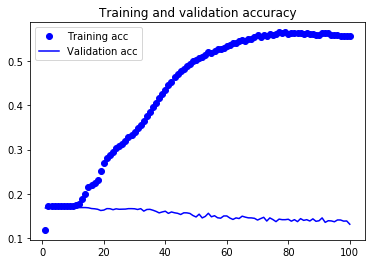

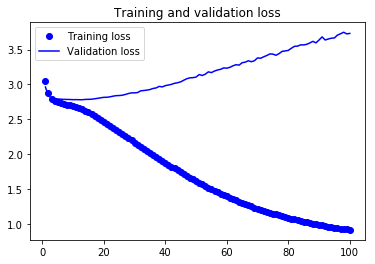

In [95]:
acc = model_conv1d_history.history['acc']
val_acc = model_conv1d_history.history['val_acc']
loss = model_conv1d_history.history['loss']
val_loss = model_conv1d_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plot(epochs, acc, 'bo', label='Training acc')
plot(epochs, val_acc, 'b', label='Validation acc')
title('Training and validation accuracy')
legend()

figure()
plot(epochs, loss, 'bo', label='Training loss')
plot(epochs, val_loss, 'b', label='Validation loss')
title('Training and validation loss')
legend()

show()

## 7. Results and Discussion

The results are pretty abominable with these models. The longer I went on training, the worse the validation accuracy got, which goes to show that this approach is not great for the given task. I don't know what kind of a model would be good for this kind of problem. A random guess from 23 categories would have resulted in about 4% accuracy (assuming there are similar amounts of entries in each category, which there aren't) so the result is still above baseline even after 100 epochs in both cases.

## 8. Conclusions

I don't really know what is wrong with my models, but they aren't great. Validation accuracy seems to get successively worse after each epoch and is at it's highest right at the start, so this approach is obviously horribly unviable. Training the models took a long time and I didn't have extra time for tweaking the models and trying different layer structures, so I'm going to have to stick with this. 